# Explore here

pip install pandas numpy matplotlib scikit-learn seaborn xgboost

In [49]:
# Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.metrics import specificity_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import joblib

In [2]:
df = pd.read_csv('../diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Analisis exploratorio de los datos

In [3]:
df.shape

(768, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
n_unicos = df.nunique()
n_unicos

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Analisis 

Se encuentran valores en 0 como valor minimo en varias columnas lo cual no es no posible biologicamente, por lo que se requiere hacer una limpieza de datos.

Tambien se determina que la variable dpendiente a predecir será el Outcome, es decir si se diagnostica o no la diabetes en la persona.

In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
# Columnas donde un 0 probablemente representa un valor faltante (valor no valido)
cols_con_ceros_invalidos = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Mostrar cuántos ceros hay en cada columna
print("Porcentaje de ceros por columna:\n")
print((df[cols_con_ceros_invalidos].isin([0]).sum()/(len(df)))*100)

# Filas que tienen al menos un cero en alguna de esas columnas
filas_con_ceros = df[df[cols_con_ceros_invalidos].isin([0]).any(axis=1)]
print(f"\nFilas con al menos un cero en columnas inválidas: {len(filas_con_ceros)}")

# Filas que tienen ceros en todas esas columnas
filas_con_todos_ceros = df[df[cols_con_ceros_invalidos].isin([0]).all(axis=1)]
print(f"Filas con ceros en TODAS esas columnas: {len(filas_con_todos_ceros)}")

Porcentaje de ceros por columna:

Pregnancies      14.453125
Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
dtype: float64

Filas con al menos un cero en columnas inválidas: 432
Filas con ceros en TODAS esas columnas: 0


Analisis:

Hasta el momento no es posible eliminar ninguna fila, ya que ninguna es complemente invalida, sin embargo con la informacioón obtenida vemos que las columnas SkinThickness e Insulin poseen un gran porcentaje de datos que no son validos, haciendo que nos preguntemos si valga la pena conservarlas.

Vamos a eliminar las columnas SkinThickness e Insulin debido a la gran cantidad de datos faltantes, y su posible relacion con los demas datos

Tambien se tomo el dato de los 0 en Pregnancies para analizar si es posible que el dataset solo este considerado para mujeres, por que de alli se viabilizaria conservar esta variable. como vemos se obtuvo un 85.5% aprox de datos => 1, por lo que es altamente probable que todas sean mujeres, se considerará entonces conservar por ahora la columna.

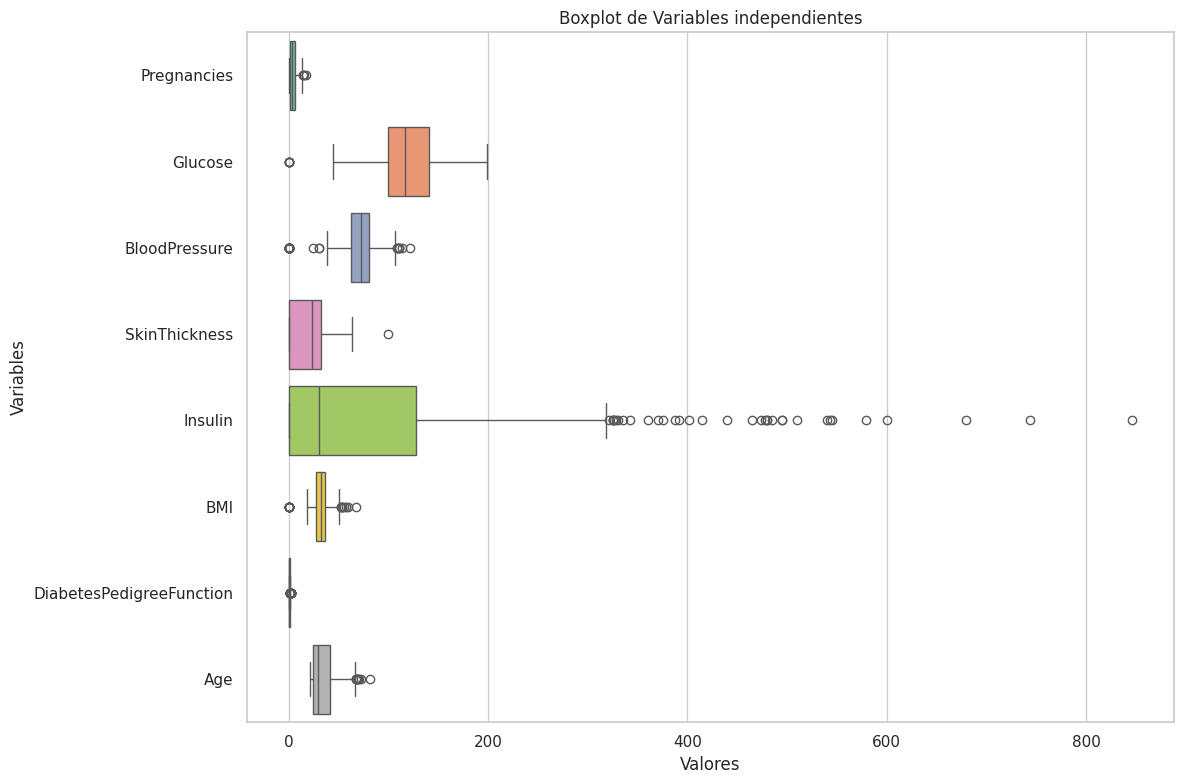

In [10]:
# Estilo de seaborn
sns.set(style="whitegrid")

# Columnas numéricas (excluimos 'Outcome' porque es categórica: 0 o 1)
col_bigotes = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear boxplot
sns.boxplot(data=df[col_bigotes], orient="h", palette="Set2")

# Título
plt.title('Boxplot de Variables independientes')
plt.xlabel('Valores')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()

In [11]:
# Eliminar columnas Insulin y SkinThickness debido a que tienen gran porcentaje (29 - 50 %) de datos en 0 
# lo cual se interpreta como dato no medido o ingresado ya que no es posible medicamente
df.drop(['Insulin','SkinThickness'], axis=1,inplace=True)

In [12]:
# Copiamos el DataFrame por seguridad
df_knn = df.copy()

# Columnas donde 0 no tiene sentido 
col_imputar = ['Glucose', 'BloodPressure', 'BMI']

# Reemplazar 0 por nan solo en esas columnas
df_knn[col_imputar] = df_knn[col_imputar].replace(0, np.nan)

# Crear el imputador KNN con 3 vecinos
imputador = KNNImputer(n_neighbors=3)

# Aplicar imputación KNN
df_imputado = pd.DataFrame(imputador.fit_transform(df_knn), columns=df_knn.columns)

# convertimos en enteros las columnas que lo eran originalmente
df_imputado['Pregnancies'] = df_imputado['Pregnancies'].round().astype(int)
df_imputado['Age'] = df_imputado['Age'].round().astype(int)
df_imputado['Outcome'] = df_imputado['Outcome'].round().astype(int)

# Verificamos que ya no haya NaNs
print(df_imputado[col_imputar].isnull().sum())

Glucose          0
BloodPressure    0
BMI              0
dtype: int64


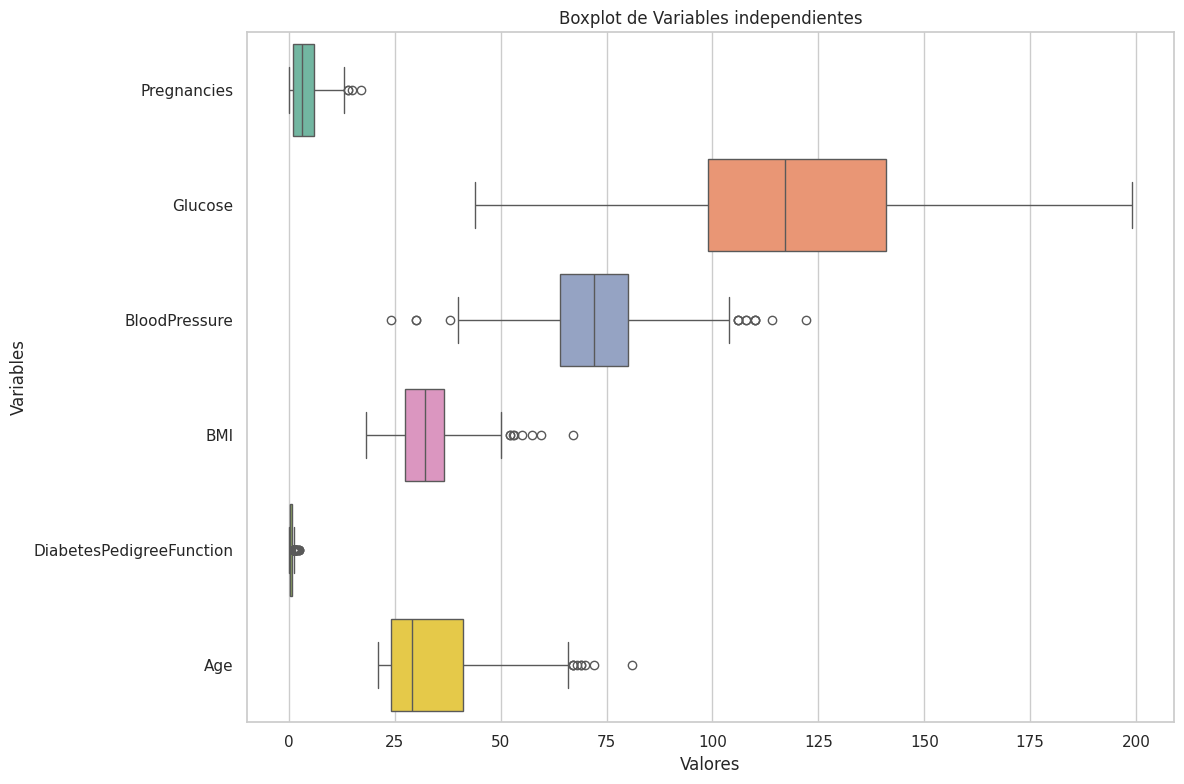

In [13]:
# Estilo de seaborn
sns.set(style="whitegrid")

# Columnas numéricas
col_bigotes2 = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear boxplot
sns.boxplot(data=df_imputado[col_bigotes2], orient="h", palette="Set2")

# Título
plt.title('Boxplot de Variables independientes')
plt.xlabel('Valores')
plt.ylabel('Variables')

plt.tight_layout()
plt.show()

Tras eliminar las columnas con demasiados faltantes e imputar valores no validos de 'Glucose', 'BloodPressure', 'BMI' Se obtienen distribuciones mas normales de las variables independientes a usar, por lo que procedemos con los siguientes pasos del analisis

## Particion de los datos train y test

In [14]:
X = df_imputado.drop(['Outcome'],axis=1)
y = df_imputado['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(614, 6)

In [16]:
X_test.shape

(154, 6)

Ya que los arboles de decision no son susceptible a outliners no se hara observacion ni corte de influyentes, pero si validamos caracteristicas importantes:

## Selección de características



In [17]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
# Creamos un df de importancias de características
dict_data = {'Feature':X_train.columns, 'Importancia':xgb_model.feature_importances_*100}
df_imp = pd.DataFrame(dict_data)
# Ordenar descendentemente por importancia
df_imp.sort_values(by='Importancia', ascending=False, inplace=True)

In [18]:
# Nombres de columnas con una importancia mayor igual a un 1%
df_imp[df_imp['Importancia']>=1]

,Feature,Importancia
1,Glucose,29.520073
5,Age,22.734591
3,BMI,20.120934
4,DiabetesPedigreeFunction,12.970429
2,BloodPressure,7.868505
0,Pregnancies,6.785465


Todas las 6 columnas son importantes asi que se conservarán

# Arboles de decisión

In [19]:
# Arbol simple
simple_tree = DecisionTreeClassifier(max_depth=3, max_features=X_train.shape[1]//2, min_samples_leaf=10, min_samples_split=30, random_state=42)
simple_tree.fit(X_train, y_train)

# Arbol complejo
complex_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)
complex_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)

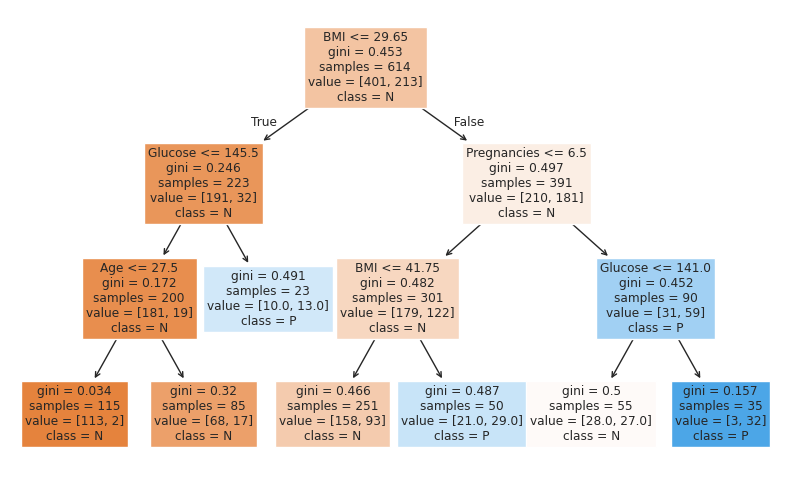

In [20]:
# Visualiza el árbol de decisión gráficamente
plt.figure(figsize=(10, 6))
plot_tree(simple_tree, feature_names=X_train.columns, class_names=['N','P'], filled=True) # N=negativo P=positivo diabetes
plt.show()

In [21]:
# Interpretación del árbol simple en texto plano
text_representation = export_text(simple_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- BMI <= 29.65
|   |--- Glucose <= 145.50
|   |   |--- Age <= 27.50
|   |   |   |--- class: 0
|   |   |--- Age >  27.50
|   |   |   |--- class: 0
|   |--- Glucose >  145.50
|   |   |--- class: 1
|--- BMI >  29.65
|   |--- Pregnancies <= 6.50
|   |   |--- BMI <= 41.75
|   |   |   |--- class: 0
|   |   |--- BMI >  41.75
|   |   |   |--- class: 1
|   |--- Pregnancies >  6.50
|   |   |--- Glucose <= 141.00
|   |   |   |--- class: 0
|   |   |--- Glucose >  141.00
|   |   |   |--- class: 1



Analisis del modelo simple:

El modelo parte de una decision bastante clara que es el indice de masa corporal (BMI) en ingles <= 29.65 camino de la izq, donde el diagnostico tiende a ser negativo y >29.65 donde el diagnostico tiende a ser positivo. 

En el camino donde el BMI es alto toma decisiones basados en el numero de embarazos e indice de glucosa, en este camino solo se encuentra una hoja que es cercana a ser pura, 3/32 con un gini de 0.157 para un decision de P muy concluyente, en el extremo inferior derecho, las demas decisiones se encuentran con relaciones muy cercanas a 50%, lo cual no considero muy conveniente.

En el camino de la izquiera, en el extremo se encuentran relaciones bastante buenas, 191/32 seguido de 181/19 y finalmente 113/2, aunque en ese camino la decision de la edad parece innesaria por que en ambas hojas el diagnostico es Negavito.

En este punto consiero que seria bueno hacer una busqueda de hiperparametros para encontrar un mejor ajuste del modelo, sin embargo se continuara con la generacion de un modelo de arbol complejo.

In [22]:
# Calculo de metricas para validación de los modelos
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [23]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex = complex_tree.predict(X_train)
test_pred_complex = complex_tree.predict(X_test)

# Evaluar el modelo simple en entrenamiento y prueba
train_pred_simple = simple_tree.predict(X_train)
test_pred_simple = simple_tree.predict(X_test)

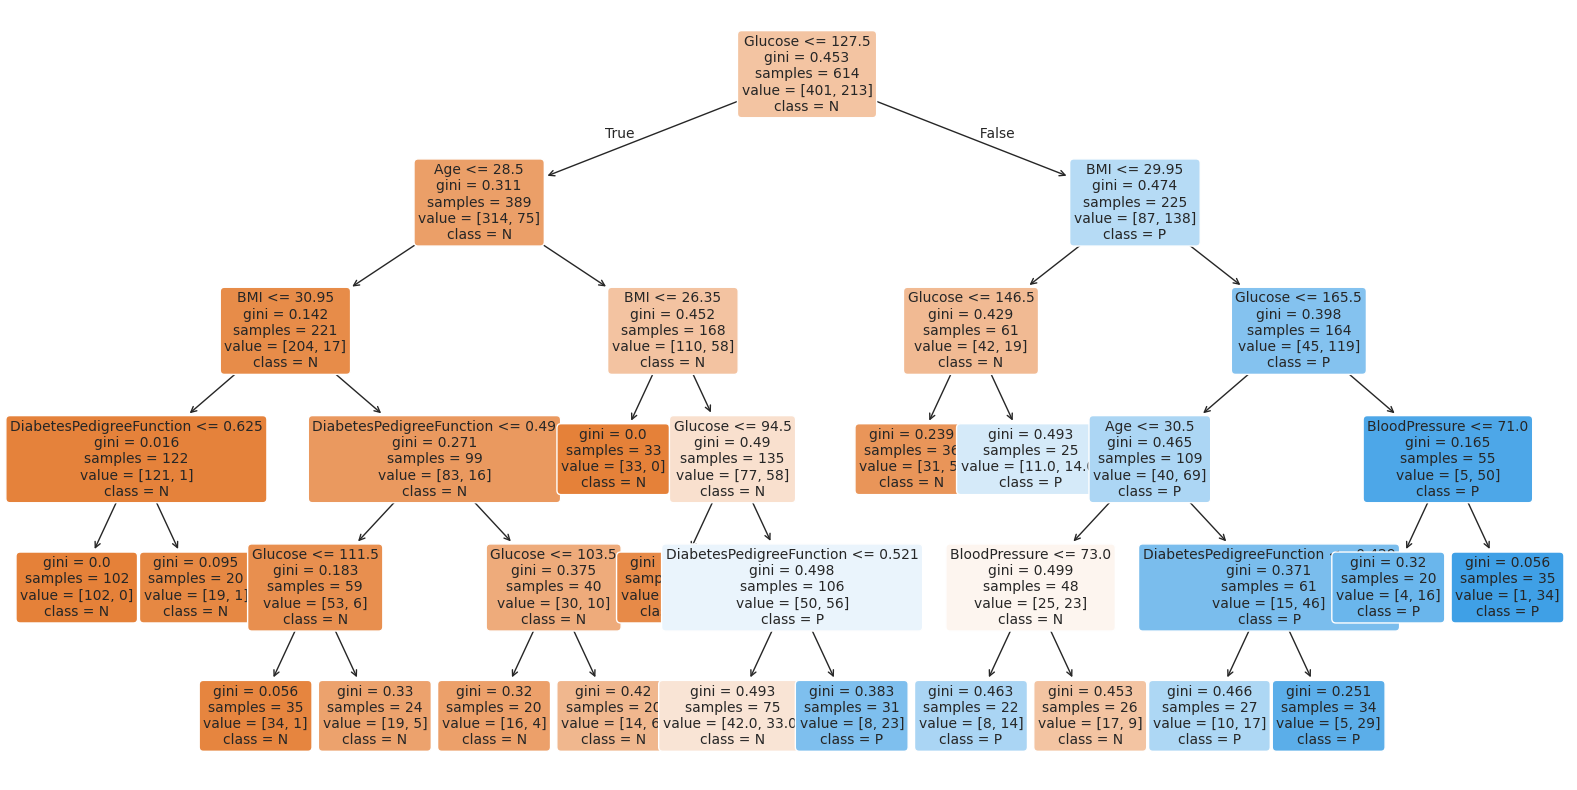

In [24]:
# Configurar el tamaño de la figura
plt.figure(figsize=(20, 10), dpi=100)

# Graficar el árbol complejo
plot_tree(complex_tree, 
          feature_names=X_train.columns, 
          class_names=['N', 'P'],  # 0 -> 'N' (negativo), 1 -> 'P' (positivo)
          filled=True, 
          rounded=True, 
          fontsize=10)

# Mostrar el gráfico
plt.show()

Comentario: Siempre me gusta obtener graficas de los procesos para tener una idea mas clara, sin emabrgo con esto se concluye que el modelo es bastante mas complejo y visualmente no es facil de analizar

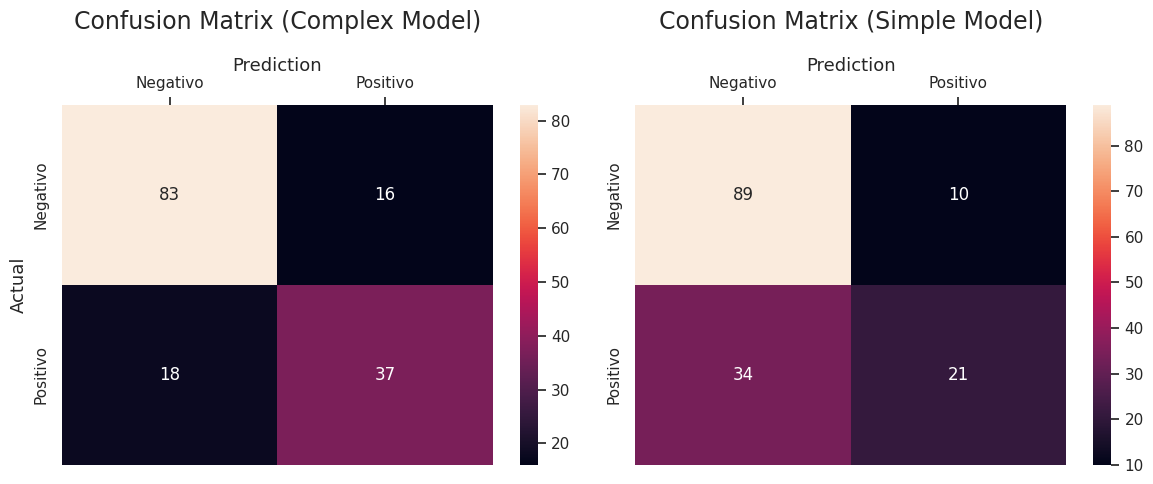

In [25]:
# Calcular las matrices de confusión para ambos modelos
cm_complex = confusion_matrix(y_test, test_pred_complex)  # Matriz de confusión del modelo complejo
cm_simple = confusion_matrix(y_test, test_pred_simple)    # Matriz de confusión del modelo simple

# Crear una figura con dos subgráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico 1: Matriz de confusión del modelo complejo (izquierda)
sns.heatmap(cm_complex, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax1)
ax1.set_ylabel('Actual', fontsize=13)
ax1.set_title('Confusion Matrix (Complex Model)', fontsize=17, pad=20)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Prediction', fontsize=13)
ax1.xaxis.tick_top()

# Gráfico 2: Matriz de confusión del modelo simple (derecha)
sns.heatmap(cm_simple, 
            annot=True, 
            fmt='g', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'], 
            ax=ax2)
ax2.set_title('Confusion Matrix (Simple Model)', fontsize=17, pad=20)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Prediction', fontsize=13)
ax2.xaxis.tick_top()

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Comentario: Matriz de confusion aplicada al modelo complejo con los datos de test que en total son 154, a grandes rasgos se observan grandes porcentajes de errores, vamos a analizar las metricas para mayor claridad.

In [26]:
# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex, test_pred_complex)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.815961,0.722359,0.786467,0.757732,0.690141,0.882793
Test,0.779221,0.685185,0.755556,0.698113,0.672727,0.838384
Diferencia,0.036740,0.037174,0.030911,0.059619,0.017414,0.044409


In [27]:
# Métricas del modelo simple
get_metrics(y_train, y_test, train_pred_simple, test_pred_simple)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.718241,0.461059,0.631315,0.685185,0.347418,0.915212
Test,0.714286,0.488372,0.640404,0.677419,0.381818,0.898990
Diferencia,0.003955,-0.027313,-0.009089,0.007766,-0.034400,0.016222


El modelo complejo es mucho mejor en metricas como exactitud, F1, Area bajo la Curva, precision, sensibilidad pero no en la especificidad, es decir que el modelo simple predice mejor los no diabeticos.

Tambien es de notar que el modelo presenta diferencia casi constante de 0.03 entre los datos de entrenamiento y ajuste, siendo mayor para los datos de entrenamiento, lo que podria concluirse como un sobreajuste en contraste con los resultados de el modelo simple donde las diferencias son mas bajas.

En ambos modelos el recall es menor a 0.7, indicando que los modelos no son muy buenos prediciendo los casos positivos.

Considero que seria buena parctica hacer una busqueda de hiperparametros para ambos modelos y validar si es realmente necesario ejecutar un modelo complejo en casos como el presente.

# Optimizacion del modelo (grid search)

In [38]:
# Definimos el algoritmo base
estimador = LGBMRegressor()

# Definimos el espacio de búsqueda
hp_dict = {'n_estimators': [5, 50, 100, 200],
           'max_depth': [2, 5, 10, 12],
           'min_child_samples': [30,40,50,60]}

# Definimos el como queremos buscar
random_search = RandomizedSearchCV(estimador, hp_dict, n_iter=10, scoring='r2', cv = 5, random_state = 42, n_jobs = -1, verbose = 3)

In [39]:
# Iniciamos la búsqueda
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] Start training from score 0.362525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV 1/5] END max_depth=12, min_child_samples=40, n_estimators=5;, score=0.133 total time=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wi

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 5, 10, 12],
                                        'min_child_samples': [30, 40, 50, 60],
                                        'n_estimators': [5, 50, 100, 200]},
                   random_state=42, scoring='r2', verbose=3)

In [40]:
random_search.best_params_

{'n_estimators': 50, 'min_child_samples': 40, 'max_depth': 2}

In [41]:
# Busqueda bayesiana
# Definimos el algoritmo base
estimador = LGBMRegressor()

# Definimos el espacio de búsqueda
hp_dict_1 = {'n_estimators': [30, 50, 70],
           'max_depth': [2, 3, 5, 7],
           'min_child_samples': [20, 30, 50, 80]}

bayes_search = BayesSearchCV(estimador, hp_dict_1, n_iter=10, scoring='r2', cv = 5, random_state = 42, n_jobs = -1, verbose = 3)

In [42]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 6
[LightGBM] [Info] Start training from score 0.362525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[CV 4/5] END max_depth=5, min_child_samples=80, n_estimators=50;, score=0.229 total time=   0.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 492, number of used features: 6
[LightGBM] [Info] Start training from score 0.337398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

BayesSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=10, n_jobs=-1,
              random_state=42, scoring='r2',
              search_spaces={'max_depth': [2, 3, 5, 7],
                             'min_child_samples': [20, 30, 50, 80],
                             'n_estimators': [30, 50, 70]},
              verbose=3)

In [43]:
bayes_search.best_params_

OrderedDict([('max_depth', 3),
             ('min_child_samples', 50),
             ('n_estimators', 70)])

In [47]:
# Arbol complejo
complex_tree2 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=42)
complex_tree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=50, random_state=42)

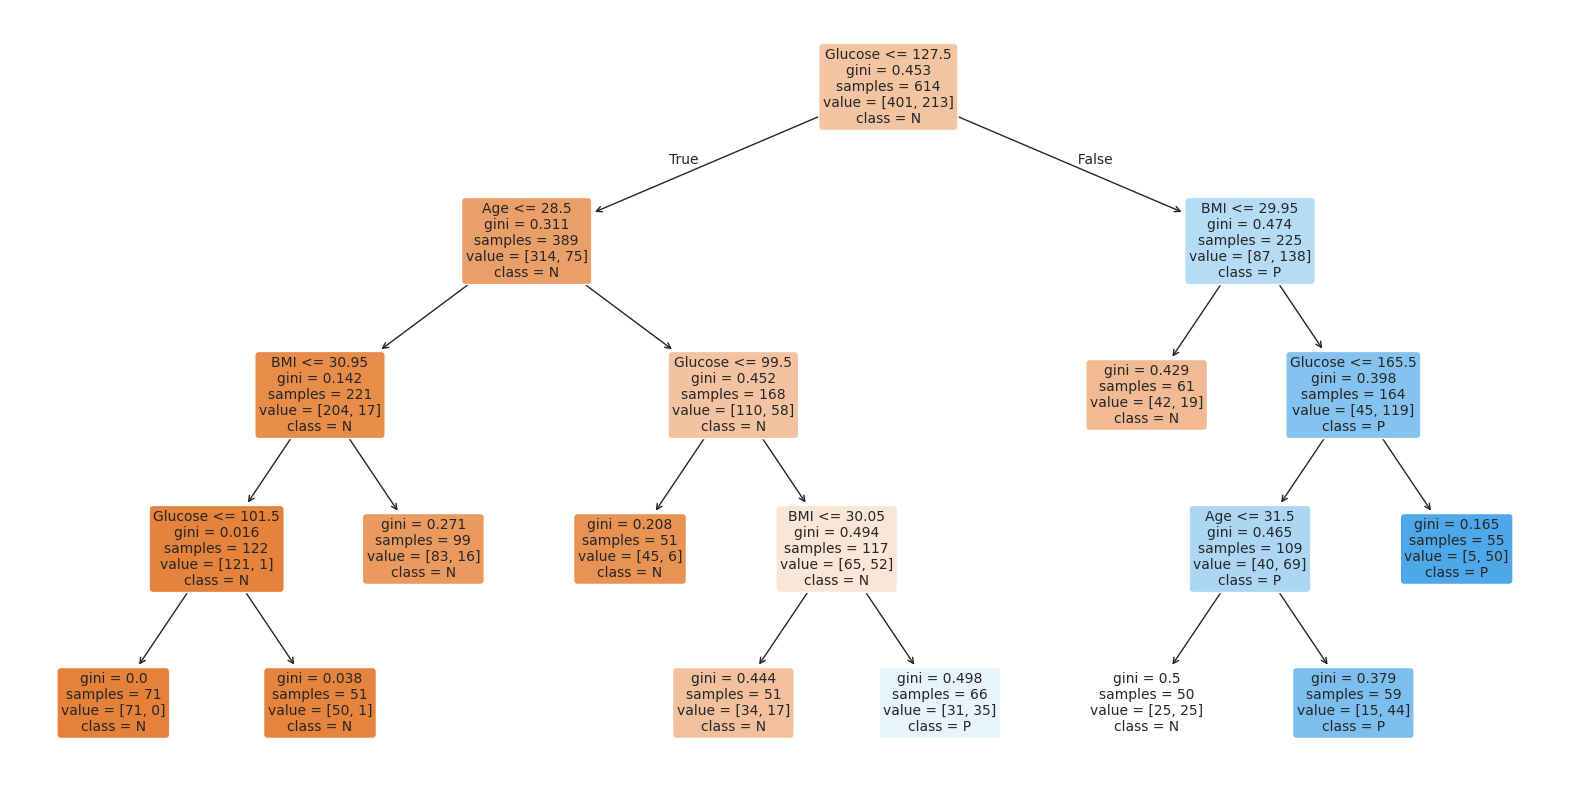

In [45]:
# Configurar el tamaño de la figura
plt.figure(figsize=(20, 10), dpi=100)

# Graficar el árbol complejo
plot_tree(complex_tree2, 
          feature_names=X_train.columns, 
          class_names=['N', 'P'],  # 0 -> 'N' (negativo), 1 -> 'P' (positivo)
          filled=True, 
          rounded=True, 
          fontsize=10)

# Mostrar el gráfico
plt.show()

In [48]:
# Evaluar el modelo complejo en entrenamiento y prueba
train_pred_complex2 = complex_tree2.predict(X_train)
test_pred_complex2 = complex_tree2.predict(X_test)

# Métricas del modelo complejo
get_metrics(y_train, y_test, train_pred_complex2, test_pred_complex2)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.773616,0.631300,0.723233,0.725610,0.558685,0.887781
Test,0.772727,0.646465,0.730303,0.727273,0.581818,0.878788
Diferencia,0.000888,-0.015165,-0.007070,-0.001663,-0.023133,0.008993


No se encuentran mejoras frente del modelo con hiperparametros calculados, es posible que el dataset posea ruido o que el modelo complejo obtenido inicialmente esta cerca del rendimiento optimo, debido a que la complejidad del problema no es alta, por ello tambien el resultado bajo en la cantidad de nodos de decision en los arboles complejos.

In [54]:
# Guardar los modelos
joblib.dump(complex_tree, '../models/complex_tree2_model.pkl')
joblib.dump(complex_tree, '../models/complex_tree_model.pkl')
joblib.dump(complex_tree, '../models/simple_tree_model.pkl')


['../models/simple_tree_model.pkl']